# Imports

In [1]:
from pathlib import Path
from imageio import imread
import geopandas as gpd
import matplotlib.pyplot as plt
import pyvista as pv
import rasterio as rio

from geograypher.cameras import MetashapeCameraSet
from geograypher.constants import DATA_FOLDER, CLASS_ID_KEY
from geograypher.entrypoints.project_detections import project_detections
from geograypher.predictors.derived_segmentors import TabularRectangleSegmentor
from geograypher.utils.visualization import create_pv_plotter

/ofo-share/repos-david/conda/envs/geograypher/lib/python3.9/site-packages/pyvista/plotting/plotter.py:149: UserWarning: 
This system does not appear to be running an xserver.
PyVista will likely segfault when rendering.

Try starting a virtual frame buffer with xvfb, or using
  ``pyvista.start_xvfb()``

  warnings.warn(


# Set constants

In [8]:
# The data folder on Google Drive should be placed in the `data` subfolder of the repository
DETECTIONS_DATA_FOLDER = Path(DATA_FOLDER, "example_detection")
INPUT_FOLDER = Path(DETECTIONS_DATA_FOLDER, "inputs")
INTERMEDIATE_FOLDER = Path(DETECTIONS_DATA_FOLDER, "intermediate_results")
OUTPUT_FOLDER = Path(DETECTIONS_DATA_FOLDER, "outputs")

# Path to cameras
CAMERAS_FILENAME = Path(INPUT_FOLDER, "hidden_little_cameras.xml")
# Path to mesh
MESH_FILENAME = Path(INPUT_FOLDER, "hidden_little_mesh.ply")
# Path to images
IMAGE_FOLDER = Path(INPUT_FOLDER, "images")
# Path to detection predictions
DETECTIONS_FOLDER = Path(INPUT_FOLDER, "detections")
# Path to orthomosaic
ORTHO_FILENAME = Path(INPUT_FOLDER, "hidden_little_ortho.tif")

# Path to saved projections onto the face. Can either be read from or written to depending on the step
PROJECTIONS_TO_MESH_FILENAME = Path(
    INTERMEDIATE_FOLDER, "projections_to_mesh.npz"
)
# File to export the geospatial projections to
PROJECTIONS_TO_GEOSPATIAL_SAVEFILENAME = Path(
    OUTPUT_FOLDER, "detections_projected_to_geospatial.geojson"
)

# Focal length of the camera in pixels
DEFAULT_FOCAL_LENGTH = 8688
# Whether to run the step for projecting images to meshes
PROJECT_TO_MESH = True
# Whether to run the conversion from mesh to geospatial
CONVERT_TO_GEOSPATIAL = True
# Whether to show the mesh
VIS_MESH = True
# Whether to show the geospatial predictions
VIS_GEODATA = True

# For the ray-based approach, the tolerance between detections to consider them a match
RAY_BASED_SIMILARITY_THRESHOLD = 0.0002
# The length of the lines for visualizing the rays
VIS_LINE_LENGTH = 7

# Projection detections to mesh
Here we take the per-image detections and project them onto the faces of the mesh. If requested, these projections can be visualized and/or saved to a file for further processing. Note that you could also could convert them to geospatial coordinates using this function, but it's split into two function calls to demonstrate the functionality.

Loading transform to EPSG:4326
Loading mesh
Reading the mesh
Selecting an ROI from mesh
Extracting faces from mesh
Loading texture


Aggregating projected viewpoints:   0%|          | 0/93 [00:00<?, ?it/s]/ofo-share/repos-david/conda/envs/geograypher/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
Aggregating projected viewpoints: 100%|██████████| 93/93 [11:59<00:00,  7.73s/it]


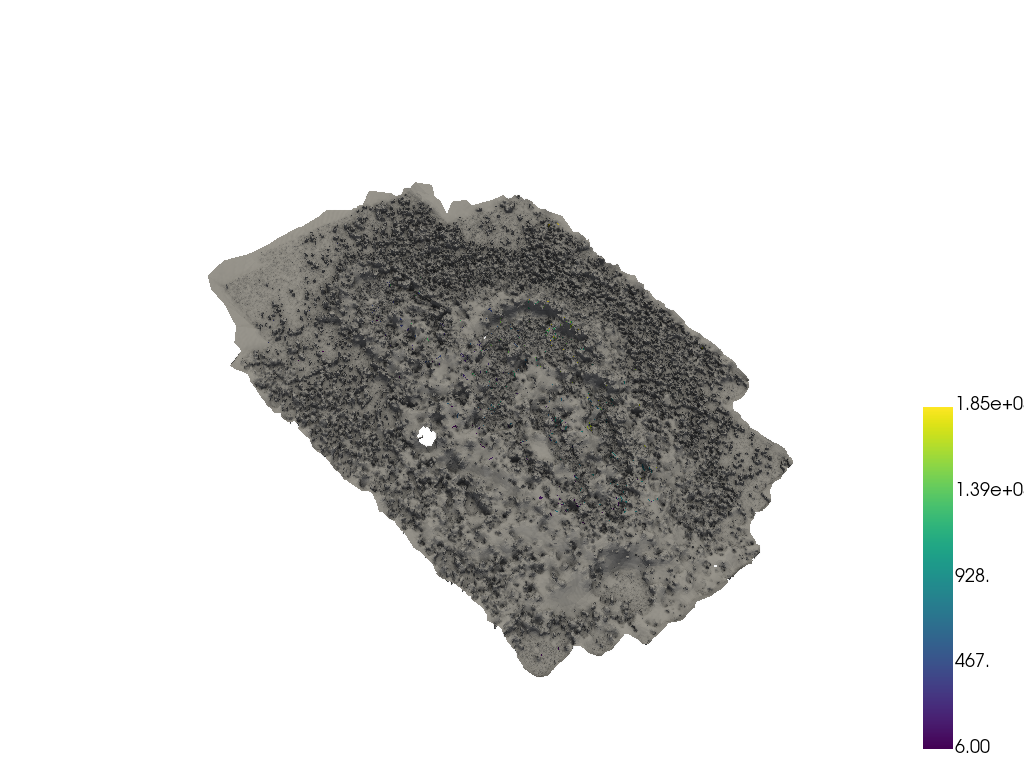

In [3]:
project_detections(
    mesh_filename=MESH_FILENAME,
    cameras_filename=CAMERAS_FILENAME,
    image_folder=IMAGE_FOLDER,
    detections_folder=DETECTIONS_FOLDER,
    projections_to_mesh_filename=PROJECTIONS_TO_MESH_FILENAME,
    projections_to_geospatial_savefilename=PROJECTIONS_TO_GEOSPATIAL_SAVEFILENAME,
    default_focal_length=DEFAULT_FOCAL_LENGTH,
    project_to_mesh=PROJECT_TO_MESH,
    vis_mesh=VIS_MESH,
)

# Convert mesh projections to geospatial
In the previous step, the per-image detections were projected to the mesh. Now, they are converted to a 2D, geospatial representation. This can be visualized and/or exported as desired.

Loading transform to EPSG:4326
Loading mesh
Reading the mesh
Selecting an ROI from mesh
Extracting faces from mesh
Loading texture
Computing working CRS
Computing faces in working CRS


Converting faces to polygons: 100%|██████████| 13489555/13489555 [03:31<00:00, 63650.28it/s]

Creating dataframe of faces


Creating dataframe of multipolygons
Plotting


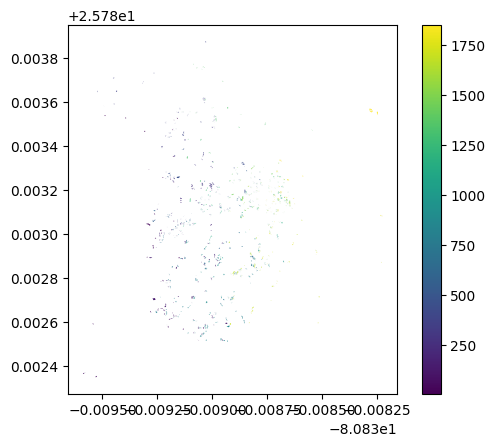

In [4]:
project_detections(
    mesh_filename=MESH_FILENAME,
    cameras_filename=CAMERAS_FILENAME,
    image_folder=IMAGE_FOLDER,
    detections_folder=DETECTIONS_FOLDER,
    projections_to_mesh_filename=PROJECTIONS_TO_MESH_FILENAME,
    projections_to_geospatial_savefilename=PROJECTIONS_TO_GEOSPATIAL_SAVEFILENAME,
    convert_to_geospatial=CONVERT_TO_GEOSPATIAL,
    vis_geodata=VIS_GEODATA,
)

# Show the orthomosaic generated for this site and optionally detections

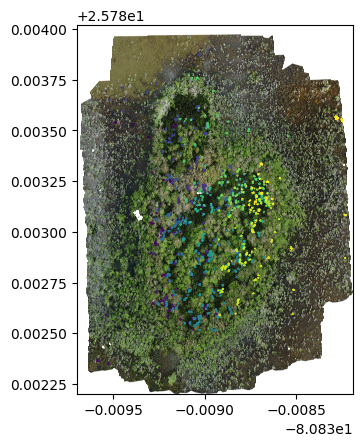

In [5]:
# Read in the orthomosaic
ortho = rio.open(ORTHO_FILENAME)

# Create axes for consistency between the two data products
_, ax = plt.subplots()
# Note this can take a while for large rasters, I'm not sure there's a way to downsample using this function
rio.plot.show(ortho, ax=ax)

# If there are projections, visualize those too
if PROJECTIONS_TO_GEOSPATIAL_SAVEFILENAME is not None and PROJECTIONS_TO_GEOSPATIAL_SAVEFILENAME.exists():
    # Read the file
    projected_detections = gpd.read_file(PROJECTIONS_TO_GEOSPATIAL_SAVEFILENAME)
    # Convert to the same CRS as the ortho
    projected_detections.to_crs(ortho.crs)
    # Plot the detections colored by the detection ID
    # This corresponding to their index in the ordered set of all detections
    projected_detections.plot(CLASS_ID_KEY, facecolor="none", ax=ax)

/tmp/ipykernel_18378/3666590026.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image_shape = imread(list(IMAGE_FOLDER.glob("*.JPG"))[0]).shape[:2]


  0%|          | 0/1851 [00:00<?, ?it/s]/ofo-share/repos-david/geograypher/geograypher/utils/numeric.py:46: RuntimeWarning: invalid value encountered in scalar divide
  a_scaler = (-ab * bc + ac * bb) / denominator
/ofo-share/repos-david/geograypher/geograypher/utils/numeric.py:47: RuntimeWarning: invalid value encountered in scalar divide
  b_scaler = (ab * ac - bc * aa) / denominator
100%|██████████| 1851/1851 [00:19<00:00, 95.41it/s] 


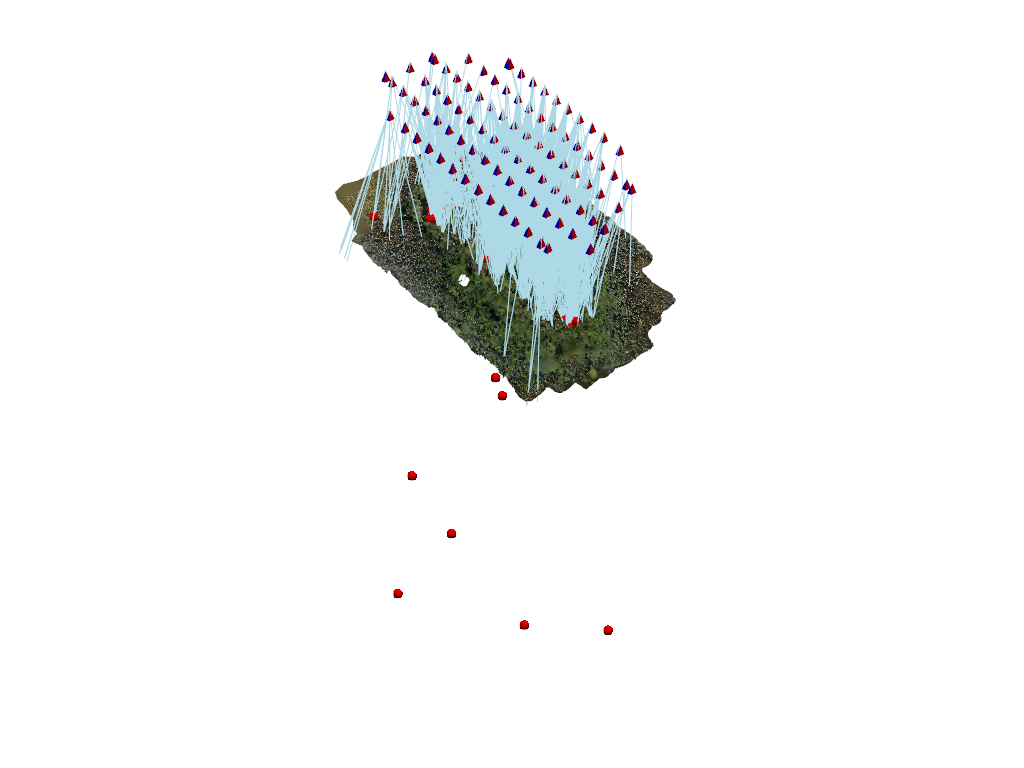

Birds were detected at the following 3D locations, in internal metashape coordinates:
[[ 8.80531686e-01  4.31828930e+00 -8.47915015e+00]
 [ 8.97272135e-01  3.97277143e+00 -8.11535952e+00]
 [ 3.26278977e+00  1.24316041e+00 -6.33029543e+00]
 [ 1.38567799e+00  4.61109231e+00 -9.76440809e+00]
 [ 5.36527947e-01  4.00952079e+00 -7.68862409e+00]
 [ 3.60700190e-01  4.99488641e+00 -7.51200547e+00]
 [ 9.56091012e-01  4.55218169e+00 -7.53965690e+00]
 [ 3.90437078e-01  4.95793611e+00 -7.62935392e+00]
 [ 8.40872961e-01  4.63581421e+00 -7.33494597e+00]
 [ 1.07634793e+00  3.69242590e+00 -7.11567268e+00]
 [ 3.00721060e+00  1.22987365e+00 -6.30696861e+00]
 [ 5.74386778e-01  5.03819986e+00 -7.60168705e+00]
 [ 3.25530377e+00  5.10382142e+00 -8.52202517e+00]
 [ 1.11995303e+00  4.37924454e+00 -1.15657562e+01]
 [ 8.84490098e-01  4.04889474e+00 -7.35846327e+00]
 [ 2.44424977e+00  4.71293863e+00 -9.42881379e+00]
 [ 9.51696953e-01  4.17574462e+00 -1.09333824e+01]
 [ 6.51772082e-01  4.43927550e+00 -7.67396540e+

In [6]:
# Create a set of cameras
camera_set = MetashapeCameraSet(
    camera_file=CAMERAS_FILENAME,
    image_folder=IMAGE_FOLDER,
    default_sensor_params={"cx": 0, "cy": 0, "f": DEFAULT_FOCAL_LENGTH}
)

# Determine the shape of the images, assuming they're all the same
image_shape = imread(list(IMAGE_FOLDER.glob("*.JPG"))[0]).shape[:2]

# Create a detector object that looks up detections from a folder. The predictions should be
# one per image in the DeepForest format.
detector = TabularRectangleSegmentor(
    pred_file_or_folder=DETECTIONS_FOLDER,
    image_folder=IMAGE_FOLDER,
    image_shape=image_shape,
    label_key="instance_ID",
)

# Create a pyvista plotter to show both scenes at once
plotter = create_pv_plotter(off_screen=False, force_xvfb=False)

# Load the mesh and plot it
mesh = pv.read(MESH_FILENAME)
plotter.add_mesh(mesh, rgb=True)

# Identify correspondences between detections and show them
detected_bird_locations = camera_set.aggreate_detections(
    segmentor=detector,
    plotter=plotter,
    similarity_threshold=RAY_BASED_SIMILARITY_THRESHOLD,
    vis_line_length=VIS_LINE_LENGTH,
)
# Show the cameras
camera_set.vis(show=True, frustum_scale=0.5, plotter=plotter)

# TODO convert these into geospatial coords
print(f"Birds were detected at the following 3D locations, in internal metashape coordinates:\n{detected_bird_locations}")